<a href="https://colab.research.google.com/github/Teoroo-CMC/DoE_Course_Material/blob/main/Week_2/Lab_1/Task_2/opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab: find optimum

In this notebook we are trying to find the maximum response 'z' of experiments conducted with two variables 'x' and 'y'. This includes design of experiments, model building, response prediction and visualisation of the collected data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools

## Experiment
This part defines you experiment. To get data from your experimental setup, just 

```python 
gaussian_function=(x, y, fwhm)
```

which will give you you result 

In [2]:
# Data generation. Doo not touch... This is your physical space :) 

def gaussian_function(x, y, pars=None, add_noise=False):
    # to be changed: genereate all data here
    np.random.seed(2)
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    # incomplete: refactor code to generate data + noise in one function
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data



This is how you call for experimental data at x=1 and y=1: 

In [39]:
z = gaussian_function(1,1)[0]

Use DoE and factioral design to locate the maxima. 

## Experimental design

In [3]:
inputs_labels = {'x': 'x', 
                 'y': 'y'}

#create list of data for high and low. 
dat = [('x', 0, 1), 
       ('y', 0, 1)]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(dat, columns=['index', 'low', 'high']).set_index('index')
inputs_df['label'] = inputs_df.index.map(lambda z: inputs_labels[z])

# compute averages and span
inputs_df['average'] = (inputs_df['high'] + inputs_df['low']) / 2
inputs_df['span'] = (inputs_df['high'] - inputs_df['low']) / 2

# encode the data
inputs_df['encoded_low'] = (inputs_df['low'] - inputs_df['average']) / inputs_df['span']
inputs_df['encoded_high'] = (inputs_df['high'] - inputs_df['average']) / inputs_df['span']

# drop average and span columns
#inputs_df = inputs_df.drop(['average', 'span'], axis=1)

inputs_df

,low,high,label,average,span,encoded_low,encoded_high
index,,,,,,,
x,0,1,x,0.5,0.5,-1.0,1.0
y,0,1,y,0.5,0.5,-1.0,1.0


In [4]:
encoded_inputs = list(itertools.product([-1, 1], repeat=len(inputs_df)))

results = pd.DataFrame(encoded_inputs)
results = results[results.columns[::-1]]
results.columns = inputs_df.index

results

index,x,y
0,-1,-1
1,1,-1
2,-1,1
3,1,1


In [5]:
real_experiment = results.copy()

var_labels = []
for var in inputs_df.index:
    var_label = inputs_df.loc[var, 'label']
    var_labels.append(var_label)
    real_experiment[var_label] = inputs_df.loc[var, 'low'] * (real_experiment[var] < 0) + inputs_df.loc[var, 'high'] * (real_experiment[var] >= 0)

print("The values of each real variable in the experiment:")
real_experiment[var_labels]

The values of each real variable in the experiment:


index,x,y
0,0,0
1,1,0
2,0,1
3,1,1


### Add observations

In [6]:
# Draw observations from the experimental space (function at the top)
results['z']= gaussian_function(real_experiment['x'],real_experiment['y'])[0]

results

index,x,y,z
0,-1,-1,5.326879
1,1,-1,1.173908
2,-1,1,7.205567
3,1,1,1.587923


### Compute effects

In [7]:
# Compute the mean effect of the factor on the response, conditioned on each variable
labels = ['x', 'y']

# Start with the constant effect: this is z-bar
zbar = results['z'].mean()
print('zbar is', zbar)

# Compute main effects
main_effects = {}
for key in labels:
    average_effects = results.groupby(key)['z'].mean()
    main_effects[key] = sum([i * average_effects[i] for i in [-1, 1]])
print('Main effects:')
print(main_effects)

# Compute two-way interaction effects
twoway_labels = list(itertools.combinations(labels, 2))
twoway_effects = {}
for key in twoway_labels:
    effects = results.groupby([key[0],key[1]])['z'].mean()
    twoway_effects[key] = sum([i * j * effects[i][j] / 2 for i in [-1,1] for j in [-1,1] ])
print('Secondary effects:')
twoway_effects

zbar is 3.8235692245509028
Main effects:
{'x': -4.885307626742085, 'y': 1.146351221231808}
Secondary effects:


{('x', 'y'): -0.7323364682467116}

In [8]:
z = results['z']
x = results[labels]
x = sm.add_constant(x)

res1 = smf.ols(formula='z ~ x + y + x:y', data=results).fit()

print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                nan
Time:                        10:08:46   Log-Likelihood:                 132.92
No. Observations:                   4   AIC:                            -257.8
Df Residuals:                       0   BIC:                            -260.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8236        inf          0        n

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:1512: RuntimeWarning: invalid value encountered in multiply
 

### Steepest ascent (and second experiment)

With our model obtained from the above linear regression, we now know the direction of the steepest ascent. We can now perform a series of experiments along this direction to close in on the maxima.

In [9]:
# Define origin
origin = [0, 0]

# Get coefficient values from regression results
coefficients = {
    'x': res1.params['x'],
    'y': res1.params['y'],
    'x:y': res1.params['x:y']
}

# Compute delta based on coefficients
delta_x = -0.2
delta_y = delta_x * coefficients['y'] / coefficients['x']
delta = [delta_x, delta_y]

# Create sequence of points
march = []
for i in range(0, 6):
    # Predict the next (x,y) point based on the regression model
    next_point = {
        'x': origin[0] + (i + 1) * delta[0],
        'y': origin[1] + (i + 1) * delta[1]
    }
    march.append(next_point)

# Decode x and y values and call function (collect output data)
March = pd.DataFrame(march, columns=['x', 'y'])
March['x_decoded'] = (March['x'] * inputs_df['span']['x'] + inputs_df['average']['x'])
March['y_decoded'] = (March['y'] * inputs_df['span']['y'] + inputs_df['average']['y'])
March['z'] = gaussian_function(March['x_decoded'], March['y_decoded'])[0]

March

,x,y,x_decoded,y_decoded,z
0,-0.2,0.046931,0.4,0.523465,8.281639
1,-0.4,0.093861,0.3,0.546931,9.160855
2,-0.6,0.140792,0.2,0.570396,9.752752
3,-0.8,0.187722,0.1,0.593861,9.992861
4,-1.0,0.234653,0.0,0.617326,9.854260
5,-1.2,0.281583,-0.1,0.640792,9.352543


Text(0, 0.5, 'Yield')

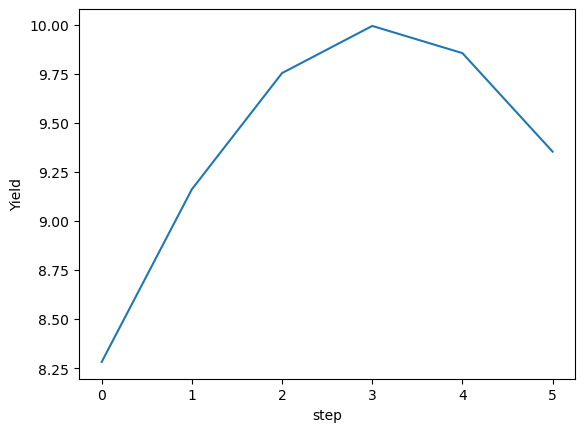

In [82]:
# Plot response values
ax = March['z'].plot()
ax.set_xlabel("step")
ax.set_ylabel("Yield")

In [10]:
# Find maximum point
max_point = March.loc[March['z'].idxmax()]

# Convert maximum point from encoded to decoded form
maximum = inputs_df.copy()
maximum['encoded_max'] = max_point[['x', 'y']].values
maximum['decoded_max'] = max_point[['x_decoded', 'y_decoded']].values

# Display encoded and decoded maximum values
maximum[['encoded_max', 'decoded_max']]

,encoded_max,decoded_max
index,,
x,-0.800000,0.100000
y,0.187722,0.593861


### Plot collected data in a scatter plot

Illustrate the datapoints we have so far collected with a scatter plot in our real space

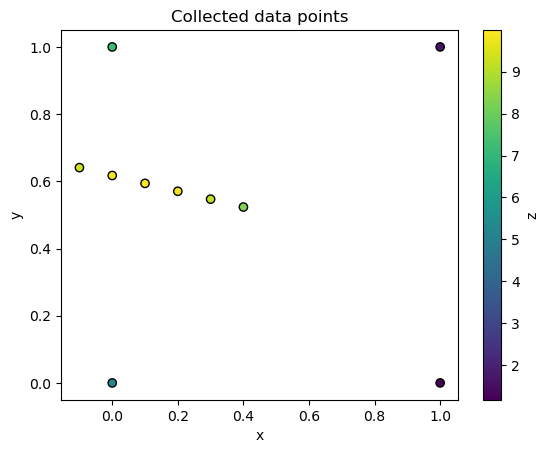

In [11]:
# Extract x, y, and z values from "real_experiment" and results" dataframe
x_real = real_experiment['x']
y_real = real_experiment['y']
z_results = results['z']

# Extract x, y, and z values from "March" dataframe
x_march = March['x_decoded']
y_march = March['y_decoded']
z_march = March['z']

# Create a new dataframe for the scatter plot
scatter_data = pd.DataFrame({'x': np.concatenate([x_real, x_march]),
                             'y': np.concatenate([y_real, y_march]),
                             'z': np.concatenate([z_results, z_march])})

# Plot the scatter plot of discrete points
plt.scatter(scatter_data['x'], scatter_data['y'], c=scatter_data['z'],
            cmap='viridis', edgecolors='black')
plt.colorbar(label='z')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Collected data points')
plt.show()

We now have a rough maximum. If we want to get more precise, we can make another four/five point experiment closer to the maxima, and build a new model.

## Refining the model

Let's use some of the data that we have already collected to minimize the amount of new experiments. 

We can then make a rectangle of data points, with the previously found maxima as a centre point, and the two adjacent points as two of the corners (see scatter plot further down for clarification).

In [12]:
# Make a new list of data for high and low, based around the maxima. Add a centre point for a more accurate model. 
dat2 = [('x', 0.0, 0.1, 0.2), 
       ('y', 0.570396, 0.593861, 0.617326)]

# create pandas dataframe in a pandas dataframe
inputs2_df = pd.DataFrame(dat2,columns=['index','low','center','high']).set_index('index')
inputs2_df['label'] = inputs2_df.index.map(lambda z: inputs_labels[z])

# compute averages and span
inputs2_df['average'] = (inputs2_df['high'] + inputs2_df['low']) / 2
inputs2_df['span'] = (inputs2_df['high'] - inputs2_df['low']) / 2

# encode the data
inputs2_df['encoded_low'] = (inputs2_df['low'] - inputs2_df['average']) / inputs2_df['span']
inputs2_df['encoded_center'] = (inputs2_df['center'] - inputs2_df['average']) / inputs2_df['span']
inputs2_df['encoded_high'] = (inputs2_df['high'] - inputs2_df['average']) / inputs2_df['span']

# Print dataframe
inputs2_df

,low,center,high,label,average,span,encoded_low,encoded_center,encoded_high
index,,,,,,,,,
x,0.000000,0.100000,0.200000,x,0.100000,0.100000,-1.0,0.0,1.0
y,0.570396,0.593861,0.617326,y,0.593861,0.023465,-1.0,0.0,1.0


In [13]:
encoded_inputs2 = list(itertools.product([-1, 1], repeat=len(inputs2_df)))
for i in range(0,1):
    encoded_inputs2.append((0,0))

results2 = pd.DataFrame(encoded_inputs2)
results2 = results2[results2.columns[::-1]]
results2.columns = inputs2_df.index

results2

index,x,y
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0


In [14]:
real_experiment2 = results2.copy()

var_labels2 = inputs2_df['label'].tolist()
real_experiment2[var_labels2] = results2.apply(
    lambda z: inputs2_df.loc[:, 'low'].where(z < 0, inputs2_df.loc[:, 'high'].where(z > 0, inputs2_df.loc[:, 'center'])),
    axis=1
)

print("The values of each real variable in the experiment:")
real_experiment2[var_labels2]

The values of each real variable in the experiment:


index,x,y
0,0.0,0.570396
1,0.2,0.570396
2,0.0,0.617326
3,0.2,0.617326
4,0.1,0.593861


### Add observations (Third experiment)

Note that only two new data points are collected in this experiment.

In [15]:
# Draw observations from the experimental space (function at the top)
results2['z']= gaussian_function(real_experiment2['x'],real_experiment2['y'])[0]

results2

index,x,y,z
0,-1,-1,9.872098
1,1,-1,9.752752
2,-1,1,9.854261
3,1,1,9.735130
4,0,0,9.992861


In [16]:
# Compute the mean effect of the factor on the response, conditioned on each variable

# Start with the constant effect: this is z-bar
zbar2 = results2['z'].mean()
print('zbar is', zbar2)

# Compute main effects
main_effects2 = {}
for key in labels:
    average_effects2 = results2.groupby(key)['z'].mean()
    main_effects2[key] = sum([i * average_effects2[i] for i in [-1, 1]])
print('Main effects:')
print(main_effects2)

# Compute two-way interaction effects
twoway_effects2 = {}
for key in twoway_labels:
    effects2 = results2.groupby([key[0],key[1]])['z'].mean()
    twoway_effects2[key] = sum([i * j * effects2[i][j] / 2 for i in [-1,1] for j in [-1,1] ])

print('Secondary effects:')
twoway_effects2

zbar is 9.841420202572753
Main effects:
{'x': -0.11923873751242553, 'y': -0.01772973775002562}
Secondary effects:


{('x', 'y'): 0.00010782162493416791}

In [20]:
z = results2['z']
x = results2[labels]
x = sm.add_constant(x)

# Fit a second-order polynomial regression model
model_formula = 'z ~ x + y + x:y + I(x**2) + I(y**2)'
res2 = smf.ols(formula=model_formula, data=results2).fit()

print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 13 Jun 2023   Prob (F-statistic):                nan
Time:                        10:09:37   Log-Likelihood:                 147.64
No. Observations:                   5   AIC:                            -285.3
Df Residuals:                       0   BIC:                            -287.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9929        inf          0        n

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [21]:
# Define the range of x and y values for prediction
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)

# Create a meshgrid of x and y values
X_mesh, Y_mesh = np.meshgrid(x_range, y_range)

# Flatten the meshgrid into 1D arrays
x_flat = X_mesh.flatten()
y_flat = Y_mesh.flatten()

# Create a DataFrame with the flattened x and y values
prediction_data = pd.DataFrame({'x': x_flat, 'y': y_flat})

# Add a constant column to the prediction data
prediction_data = sm.add_constant(prediction_data)

# Predict the response values for the prediction data
predictions = res2.predict(prediction_data)

# Find the index of the maximum predicted response value
max_index2 = predictions.idxmax()

# Extract the corresponding input values for the maximum point
max_point2 = prediction_data.loc[max_index2, ['x', 'y']]

# Decode the maximum point to obtain the real values
max_point_decoded = pd.Series({
    'x_decoded': max_point2['x'] * inputs2_df.loc['x', 'span'] + inputs2_df.loc['x', 'average'],
    'y_decoded': max_point2['y'] * inputs2_df.loc['y', 'span'] + inputs2_df.loc['y', 'average']
})

# Calculate the maximum response value
max_z = predictions[max_index2]

# Create a DataFrame for the maximum point
max_point_df = pd.DataFrame([max_point_decoded]).rename(index={0: 'Maximum Point'})

# Add the maximum response value to the DataFrame
max_point_df['z'] = max_z

print('Maximum Point:')
max_point_df

Maximum Point:


,x_decoded,y_decoded,z
Maximum Point,0.068687,0.592676,10.002456


## Visualisation of maximum and collected data

If we want, we can now plot the predicted surface to visualise the result.

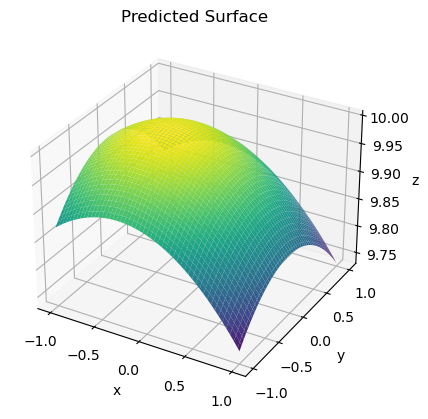

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Reshape the predictions array to match the meshgrid shape
Z_mesh = predictions.values.reshape(X_mesh.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X_mesh, Y_mesh, Z_mesh, cmap='viridis')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Predicted Surface')

# Show the plot
plt.show()

And we can plot all the collected data points in real space

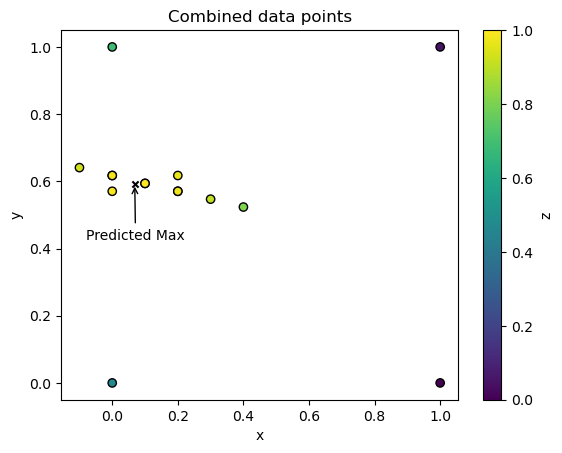

In [23]:
# Extract x, y, and z values from "real_experiment2" dataframe
x_real2 = real_experiment2[var_labels2]['x']
y_real2 = real_experiment2[var_labels2]['y']
z_results2 = results2['z']

# Create a new dataframe for the additional data points
third_exp = pd.DataFrame({'x': x_real2, 'y': y_real2, 'z': z_results2})

# Concatenate the additional data points with the existing scatter_data dataframe
combined_data = pd.concat([scatter_data, third_exp], ignore_index=True)

# Plot the scatter plot of all data points
plt.scatter(combined_data['x'], combined_data['y'], c=combined_data['z'],
            cmap='viridis', edgecolors='black')

# Add the predicted maximum point
plt.scatter(max_point_decoded['x_decoded'], max_point_decoded['y_decoded'], c='black', marker='x', s=20)
plt.annotate('Predicted Max', xy=(max_point_decoded['x_decoded'], max_point_decoded['y_decoded']),
             xytext=(-35, -40), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'), color='black')

plt.colorbar(label='z')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Combined data points')
plt.show()